Start dates for the ETFs:
- Communication Services (XLC): 2018-06-19
- Consumer Discretionary (XLY): 1998-12-22
- Consumer Staples (XLP): 1998-12-22
- Energy (XLE): 1998-12-22
- Financials (XLF): 1998-12-22
- Health Care (XLV): 1998-12-22
- Industrials (XLI): 1998-12-22
- Materials (XLB): 1998-12-22
- Real Estate (XLRE): 2015-10-08
- Technology (XLK): 1998-12-22
- Utilities (XLU): 1998-12-22

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.random import set_seed as tf_seed

from api_key import TIINGO_API_KEY   #personal file with Tiingo API key

In [2]:
FULL_ETFS = ["XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLK", "XLU"]  #sector ETFs going back to 1998-12-22
PAST_WINDOW_LENGTH = 250    # number of past days to use in prediction
FUTURE_PREDICTION_TIME = 100  # number of days in the future to predict

### Download and save data (not necessary if old data is present and doesn't need updating for your test)

In [3]:
def download_and_save_data(sector_etfs, api_key):
    full_etf_data = pdr.get_data_tiingo(sector_etfs, start="1998-12-22", end="2019-12-31", api_key=api_key)
    full_etf_data.to_csv("full etf data.csv")
    
    dia = pdr.get_data_tiingo("DIA", start="1998-12-22", end="2019-12-31", api_key=api_key)
    dia.reset_index(level="symbol", drop=True, inplace=True)
    dia.to_csv("dia.csv")

In [4]:
download_and_save_data(FULL_ETFS, TIINGO_API_KEY)

### Load CSVs and format data for the networks

In [3]:
full_etf_data = pd.read_csv("full etf data.csv", index_col=[0,1])
dia = pd.read_csv("dia.csv", index_col=0)

In [4]:
adj_closes = full_etf_data["adjClose"].unstack("symbol")
times = adj_closes.index
adj_closes = adj_closes.values
percent_changes = 100 * (adj_closes[1:,:]/adj_closes[:-1,:] - 1)

In [5]:
# get 3d tensor for daily returns
data_length, n_etfs = percent_changes.shape
n_entries = data_length - PAST_WINDOW_LENGTH - FUTURE_PREDICTION_TIME + 1

daily_windows = np.zeros([n_entries, PAST_WINDOW_LENGTH, n_etfs,1])
for i in range(n_entries):
    daily_windows[i,:,:,0] = percent_changes[i:(i+PAST_WINDOW_LENGTH),:]

daily_windows.shape

(4940, 250, 9, 1)

In [6]:
# get djia returns
dia_close = dia["adjClose"].values
dia_start = dia_close[(PAST_WINDOW_LENGTH - 1):(n_entries + PAST_WINDOW_LENGTH - 1)]
dia_end = dia_close[(PAST_WINDOW_LENGTH + FUTURE_PREDICTION_TIME - 1):(n_entries + PAST_WINDOW_LENGTH + FUTURE_PREDICTION_TIME - 1)]
dia_returns = 100*(dia_end/dia_start - 1)

In [7]:
# insert pd.cut() call here, then add to_one_hot
INCONCLUSIVE_LEVEL = 2.5  # in units of percentage points
bins = [-np.Inf, -INCONCLUSIVE_LEVEL, INCONCLUSIVE_LEVEL, np.Inf]
classes = ["Down", "Inconclusive", "Up"]
dia_return_classes = pd.cut(dia_returns, bins=bins, labels=classes)
one_hot_classes = pd.get_dummies(dia_return_classes).values

In [8]:
# tabulate counts of each class
dia_return_classes.value_counts()

Down             916
Inconclusive    1217
Up              2807
dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(daily_windows, one_hot_classes,
                                                    stratify=dia_return_classes, random_state=1998)
y_true = np.array(classes)[np.argmax(y_test, axis=1)]

### Model 1: Fully Connected Layers Only

In [10]:
tf_seed(1)
model1 = keras.Sequential([
    keras.Input(shape=[PAST_WINDOW_LENGTH, n_etfs, 1]),
    layers.Flatten(),
    layers.Dense(200, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(100, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(3, activation="softmax")
])
model1.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist1 = model1.fit(X_train, y_train, epochs=10)

Epoch 1/10
116/116 [==============================] - 0s 2ms/step - loss: 1.6350 - accuracy: 0.4227
Epoch 2/10
116/116 [==============================] - 0s 2ms/step - loss: 1.0355 - accuracy: 0.5420
Epoch 3/10
116/116 [==============================] - 0s 2ms/step - loss: 0.9037 - accuracy: 0.6119
Epoch 4/10
116/116 [==============================] - 0s 2ms/step - loss: 0.8172 - accuracy: 0.6486
Epoch 5/10
116/116 [==============================] - 0s 1ms/step - loss: 0.7668 - accuracy: 0.6788
Epoch 6/10
116/116 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.7255
Epoch 7/10
116/116 [==============================] - 0s 2ms/step - loss: 0.6318 - accuracy: 0.7441
Epoch 8/10
116/116 [==============================] - 0s 2ms/step - loss: 0.5462 - accuracy: 0.7792
Epoch 9/10
116/116 [==============================] - 0s 2ms/step - loss: 0.5030 - accuracy: 0.8032
Epoch 10/10
116/116 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.8335

In [34]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               450200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 303       
Total params: 470,603
Trainable params: 470,603
Non-trainable params: 0
________________________________________________

In [11]:
m1_predictions = model1.predict(X_test)
m1_y_pred = np.array(classes)[np.argmax(m1_predictions, axis=1)]
m1_cm = confusion_matrix(y_true, m1_y_pred, labels=classes)
m1_cm

array([[ 10,  31, 188],
       [ 12,  38, 254],
       [ 40,  88, 574]])

In [12]:
pd.DataFrame(m1_cm, index=["True " + c for c in classes], columns=["Pred " + c for c in classes])

,Pred Down,Pred Inconclusive,Pred Up
True Down,10,31,188
True Inconclusive,12,38,254
True Up,40,88,574


In [14]:
accuracy_score(y_true, m1_y_pred)

0.5036437246963563

In [15]:
m1_cm.sum(axis=1)/m1_cm.sum()

array([0.05020243, 0.12712551, 0.82267206])

### Model 2: Minimal CNN, Over All ETFs

In [16]:
tf_seed(2)
model2 = keras.Sequential([
    keras.Input(shape=[PAST_WINDOW_LENGTH, n_etfs, 1]),
    layers.Conv2D(40, kernel_size=(30,9), activation="relu"),
    layers.Flatten(),
    layers.Dense(3, activation="softmax")
])
model2.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = model2.fit(X_train, y_train, epochs=10)

Epoch 1/10
116/116 [==============================] - 0s 3ms/step - loss: 0.9856 - accuracy: 0.5547
Epoch 2/10
116/116 [==============================] - 0s 2ms/step - loss: 0.5385 - accuracy: 0.7830
Epoch 3/10
116/116 [==============================] - 0s 2ms/step - loss: 0.3219 - accuracy: 0.8783
Epoch 4/10
116/116 [==============================] - 0s 2ms/step - loss: 0.2034 - accuracy: 0.9320
Epoch 5/10
116/116 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9636
Epoch 6/10
116/116 [==============================] - 0s 2ms/step - loss: 0.0787 - accuracy: 0.9849
Epoch 7/10
116/116 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9954
Epoch 8/10
116/116 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9995
Epoch 9/10
116/116 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 1.0000
Epoch 10/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0095 - accuracy: 1.0000

In [17]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 1, 40)        10840     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8840)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 26523     
Total params: 37,363
Trainable params: 37,363
Non-trainable params: 0
_________________________________________________________________


In [18]:
m2_predictions = model2.predict(X_test)
m2_y_pred = np.array(classes)[np.argmax(m2_predictions, axis=1)]
m2_cm = confusion_matrix(y_true, m2_y_pred, labels=classes)
m2_cm

array([[167,  55,   7],
       [ 35, 189,  80],
       [  6,  45, 651]])

In [19]:
pd.DataFrame(m2_cm, index=["True " + c for c in classes], columns=["Pred " + c for c in classes])

,Pred Down,Pred Inconclusive,Pred Up
True Down,167,55,7
True Inconclusive,35,189,80
True Up,6,45,651


In [20]:
m2_cm.diagonal()/m2_cm.sum(axis=0)

array([0.80288462, 0.65397924, 0.88211382])

In [21]:
accuracy_score(y_true, m2_y_pred)

0.8153846153846154

In [22]:
w = model2.layers[0].weights
z = w[0].numpy()

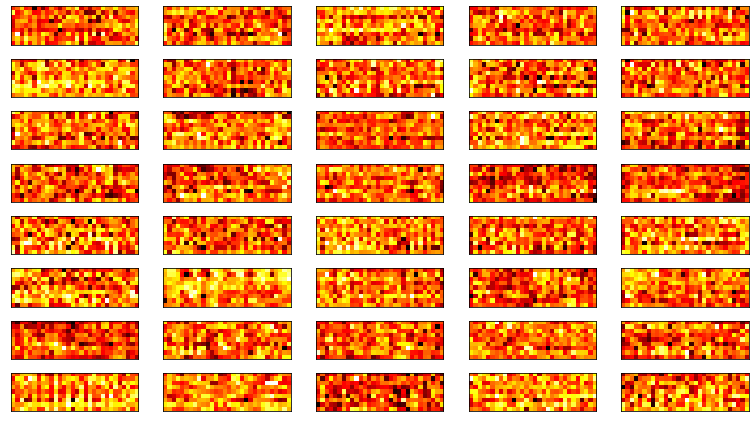

In [23]:
for i in range(40):
    plt.subplot(8,5,i+1)
    plt.imshow(z[:,:,0,i].transpose(), cmap='hot')
    plt.title("")
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(left=0, right=0.5, bottom=0, top=0.6)
fig = plt.gcf()
fig.set_size_inches(20.5, 9.5)
fig.savefig('features.png')

In [24]:
m2_outputs = [layer.output for layer in model2.layers]
activation_model = Model(inputs=model2.input, outputs=m2_outputs)
activations = activation_model.predict(X_train[0,:,:,:].reshape(1,250,9,1))

In [35]:
def display_activation1(activations, col_size, row_size, act_index, fig_name="figure.png"): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index].reshape(17,13), cmap='gray')
            activation_index += 1
    fig.savefig(fig_name)

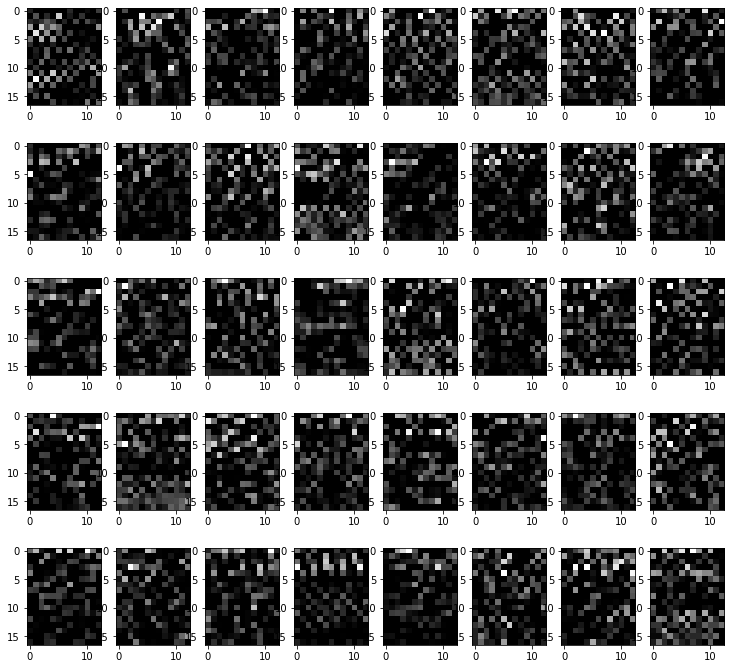

In [36]:
display_activation1(activations, 8, 5, 0, fig_name="m2_activations.png")

### Model 3: Bigger CNN, Not Over All ETFs

In [29]:
tf_seed(3)
model3 = keras.Sequential([
    keras.Input(shape=[PAST_WINDOW_LENGTH, n_etfs, 1]),
    layers.Conv2D(40, kernel_size=(5,3), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,1)),
    layers.Conv2D(80, kernel_size=(5,2), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,1)),
    layers.Conv2D(120, kernel_size=(5,2), padding="same", activation="relu"),
    layers.MaxPool2D(pool_size=(2,1)),
    layers.Flatten(),
    layers.Dense(3, activation="softmax")
])
model3.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = model3.fit(X_train, y_train, epochs=10)

Epoch 1/10
116/116 [==============================] - 2s 22ms/step - loss: 0.9965 - accuracy: 0.5646
Epoch 2/10
116/116 [==============================] - 2s 17ms/step - loss: 0.7788 - accuracy: 0.6529
Epoch 3/10
116/116 [==============================] - 2s 17ms/step - loss: 0.4907 - accuracy: 0.8054
Epoch 4/10
116/116 [==============================] - 2s 17ms/step - loss: 0.3396 - accuracy: 0.8707
Epoch 5/10
116/116 [==============================] - 2s 18ms/step - loss: 0.2641 - accuracy: 0.8999
Epoch 6/10
116/116 [==============================] - 2s 17ms/step - loss: 0.2167 - accuracy: 0.9177
Epoch 7/10
116/116 [==============================] - 2s 18ms/step - loss: 0.1761 - accuracy: 0.9293
Epoch 8/10
116/116 [==============================] - 2s 17ms/step - loss: 0.1549 - accuracy: 0.9344
Epoch 9/10
116/116 [==============================] - 2s 17ms/step - loss: 0.1251 - accuracy: 0.9514
Epoch 10/10
116/116 [==============================] - 2s 17ms/step - loss: 0.0960 - accura

In [30]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 9, 40)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 9, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 9, 80)        32080     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 9, 80)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 9, 120)        96120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 9, 120)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33480)            

In [31]:
m3_predictions = model3.predict(X_test)
m3_y_pred = np.array(classes)[np.argmax(m3_predictions, axis=1)]
m3_cm = confusion_matrix(y_true, m3_y_pred, labels=classes)
m3_cm

array([[212,  17,   0],
       [ 35, 221,  48],
       [  0,  29, 673]])

In [32]:
pd.DataFrame(m3_cm, index=["True " + c for c in classes], columns=["Pred " + c for c in classes])

,Pred Down,Pred Inconclusive,Pred Up
True Down,212,17,0
True Inconclusive,35,221,48
True Up,0,29,673


In [33]:
m3_cm.diagonal()/m3_cm.sum(axis=0)

array([0.8582996 , 0.82771536, 0.9334258 ])

In [34]:
accuracy_score(y_true, m3_y_pred)

0.8955465587044534

In [76]:
m3_outputs = [layer.output for layer in model3.layers]
m3_activation_model = Model(inputs=model3.input, outputs=m3_outputs)

In [80]:
m3_activations = m3_activation_model.predict(X_train[98,:,:,:].reshape(1,250,9,1))

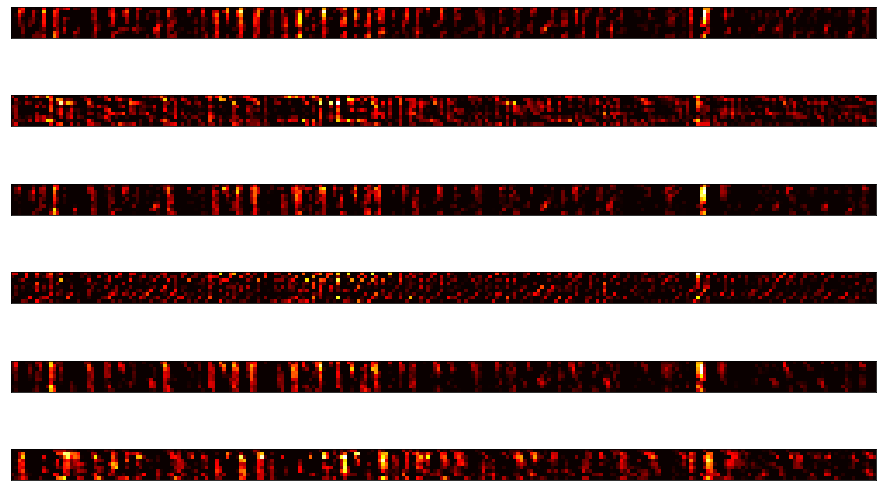

In [81]:
for i in range(6):
    plt.subplot(6,1,i+1)
    plt.imshow(m3_activations[0][0,:,:,i].transpose(), cmap='hot')
    plt.title("")
    plt.xticks([])
    plt.yticks([])

fig = plt.gcf()
fig.set_size_inches(15.5, 9.5)
fig.savefig('m3_activations.png')
plt.show()